# Merge performance metrics

In [2]:
import glob
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

## 20231106_synthetic_data

In [2]:
dir = "/ifs/scratch/jls106_gp/nhw2114/data/20231106_synthetic_data"

eakf_metrics_df = pd.read_csv(dir + '/eakf_metrics_all.csv')
epiestim_metrics_df = pd.read_csv(dir + '/epiEstim_metrics_all.csv')
eakf_metrics_badinciks_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/data/20231106_synthetic_data/eakf_metrics_badinciks_all.csv")
esrs_metrics_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/data/20231106_synthetic_data/esrs_metrics_all.csv")

In [3]:
# eakf_metrics_badinciks_df[['method', 'rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
#        'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl',
#        'avg_w2_last_epi_day', 'avg_kl_last_epi_day', 'in_ci', 'ens_var',
#        'in_ci_last_day', 'ens_var_last_day', 'in_ci_last_epi_day',
#        'ens_var_last_epi_day']].groupby('method').mean().round(4)

In [4]:
# esrs_metrics_df[['method', 'in_ci', 'ens_var', 'in_ci_last_day', 'ens_var_last_day',
#        'in_ci_last_epi_day', 'ens_var_last_epi_day']].groupby('method').mean().round(4)

In [5]:
merge_df = eakf_metrics_badinciks_df.merge(esrs_metrics_df, on=["param","method"], how="left")
merge_df.loc[merge_df.method == "smooth inflation","in_ci_x"] = merge_df.loc[merge_df.method == "smooth inflation","in_ci_y"]
merge_df.loc[merge_df.method == "smooth inflation","ens_var_x"] = merge_df.loc[merge_df.method == "smooth inflation","ens_var_y"]
merge_df.loc[merge_df.method == "smooth inflation","in_ci_last_day_x"] = merge_df.loc[merge_df.method == "smooth inflation","in_ci_last_day_y"]
merge_df.loc[merge_df.method == "smooth inflation","ens_var_last_day_x"] = merge_df.loc[merge_df.method == "smooth inflation","ens_var_last_day_y"]
merge_df.loc[merge_df.method == "smooth inflation","in_ci_last_epi_day_x"] = merge_df.loc[merge_df.method == "smooth inflation","in_ci_last_epi_day_y"]
merge_df.loc[merge_df.method == "smooth inflation","ens_var_last_epi_day_x"] = merge_df.loc[merge_df.method == "smooth inflation","ens_var_last_epi_day_y"]

In [6]:
merge_df.drop(columns=["in_ci_y","ens_var_y","in_ci_last_day_y","ens_var_last_day_y","in_ci_last_epi_day_y","ens_var_last_epi_day_y"], inplace=True)
merge_df.rename(columns={
    "in_ci_x" : "in_ci",
    "ens_var_x" : "ens_var",
    "in_ci_last_day_x" : "in_ci_last_day",
    "ens_var_last_day_x" : "ens_var_last_day",
    "in_ci_last_epi_day_x" : "in_ci_last_epi_day",
    "ens_var_last_epi_day_x" : "ens_var_last_epi_day",
}, inplace=True)

In [7]:
def compute_ci(df, by_col):
    
    mean_df = df.groupby(by_col).mean()
    median_df = df.groupby(by_col).median()
    std_df = df.groupby(by_col).std()
    n_df = df.groupby(by_col).count()

    lower_df = mean_df - 1.96 * std_df / np.sqrt(n_df)
    upper_df = mean_df + 1.96 * std_df / np.sqrt(n_df)
    # add suffixes
    lower_df = lower_df.add_suffix('_lower')
    upper_df = upper_df.add_suffix('_upper')
    mean_df = mean_df.add_suffix('_mean')
    median_df = median_df.add_suffix('_median')
    # merge
    merge_df = lower_df.merge(mean_df, on=by_col)
    merge_df = merge_df.merge(upper_df, on=by_col)
    merge_df = merge_df.merge(median_df, on=by_col)
    
    return merge_df

def dataframe_to_latex(df, columns, titles, metric_dict=None, degree=2):
    """
    Convert a Pandas DataFrame with mean, lower, and upper columns to a LaTeX table.

    Parameters:
    - df: Pandas DataFrame.
    - columns: Columns of table.

    Returns:
    - LaTeX table string.
    """
    df = df[list(titles.keys())]
    # Column row
    tab_arg = "l|" * len(columns)
    latex_table = "\ begin{tabular}{|" + tab_arg + "} \hline "
    latex_table += " & ".join([titles[col] for col in df.columns])
    latex_table += " \\\\\n \hline "
    # Data rows
    for metric, title in metric_dict.items():
        latex_table += f"{title} & "
        
        mean = df.loc[df.metric == metric + "_mean"].round(degree).values.tolist()[0]
        lower = df.loc[df.metric == metric + "_lower"].round(degree).values.tolist()[0]
        upper = df.loc[df.metric == metric + "_upper"].round(degree).values.tolist()[0]
        median = df.loc[df.metric == metric + "_median"].round(degree).values.tolist()[0]
        latex_table += " &  ".join(
            [f"{mean[i]} ({lower[i]}, {upper[i]}) " for i in range(1,len(mean))]
        )
        latex_table += " \\\\\n \hline "
    
    latex_table += "\end{tabular}"

    return latex_table

In [8]:
summ_df = merge_df[['method', 'rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
       'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl',
       'avg_w2_last_epi_day', 'avg_kl_last_epi_day', 'in_ci', 'ens_var',
       'in_ci_last_day', 'ens_var_last_day', 'in_ci_last_epi_day',
       'ens_var_last_epi_day']].groupby('method').mean().round(4)

In [9]:
epiestim_summ_df = epiestim_metrics_df[['window', 'rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
       'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl',
       'avg_w2_last_epi_day', 'avg_kl_last_epi_day', 'in_ci', 'ens_var',
       'in_ci_last_day', 'ens_var_last_day', 'in_ci_last_epi_day',
       'ens_var_last_epi_day']].groupby('window').mean(numeric_only=False).round(4)

In [10]:
merge_stats_df = compute_ci(merge_df, "method")
epiestim_stats_df = compute_ci(epiestim_metrics_df, "window")

cols_for_table1 = ['metric', 'adaptive inflation', 'fixed inflation', 'no inflation', 'smooth inflation', 8]
metric_title_dict = {
    # 'rt_peak_rmse' : '$R_t$ RMSE Peak',
    # 'rt_rmse' : '$R_t$ RMSE',
    'in_ci_last_epi_day' : 'True $R_t$ within 95\% CI',
    'rt_last_epi_day_rmse' : '$R_t$ RMSE',
    # 'ens_var' : 'Variance',
    'ens_var_last_epi_day' : 'Ensemble Variance',
    # 'data_rmse' : 'Data RMSE',
    # 'in_ci' : 'True $R_t$ within CI',
    # 'avg_w2' : '$W_2(p,q)$',
    # 'avg_kl' : '$D_{KL}(p || q)$',
    # 'data_rmse_last_epi_day' : 'Data RMSE',
    'avg_w2_last_epi_day' : '$W_2(p,q)$',
    'avg_kl_last_epi_day' : '$D_{KL}(p || q)$',
}
col_title_dict = {
    'metric' : 'Metric',
    'no inflation' : 'no inflation',
    'fixed inflation' : 'fixed inflation',
    'adaptive inflation' : 'adaptive inflation',
    'smooth inflation' : 'EnSRS adaptive inflation', 
    8 : 'EpiEstim',
}
transpose_df = merge_stats_df.T.reset_index().rename(columns={'index':'metric'})
epi_transpose_df = epiestim_stats_df[epiestim_stats_df.index == 8].T.reset_index().rename(columns={'index':'metric'})
transpose_df = transpose_df.merge(epi_transpose_df, on="metric")
print(dataframe_to_latex(transpose_df, cols_for_table1, col_title_dict, metric_title_dict))

\ begin{tabular}{|l|l|l|l|l|l|} \hline Metric & no inflation & fixed inflation & adaptive inflation & EnSRS adaptive inflation & EpiEstim \\
 \hline True $R_t$ within 95\% CI & 0.02 (0.02, 0.03)  &  0.46 (0.46, 0.47)  &  0.84 (0.83, 0.84)  &  0.84 (0.83, 0.84)  &  0.85 (0.85, 0.85)  \\
 \hline $R_t$ RMSE & 1.0 (0.99, 1.0)  &  0.51 (0.51, 0.51)  &  0.38 (0.38, 0.38)  &  0.17 (0.17, 0.17)  &  0.44 (0.44, 0.44)  \\
 \hline Ensemble Variance & 0.0 (0.0, 0.0)  &  0.03 (0.03, 0.03)  &  0.15 (0.15, 0.16)  &  0.09 (0.09, 0.1)  &  1.26 (1.25, 1.27)  \\
 \hline $W_2(p,q)$ & 0.98 (0.98, 0.98)  &  0.82 (0.82, 0.82)  &  0.66 (0.65, 0.66)  &  0.39 (0.39, 0.39)  &  0.77 (0.76, 0.77)  \\
 \hline $D_{KL}(p || q)$ & 6.63 (6.6, 6.66)  &  3.29 (3.27, 3.31)  &  0.96 (0.96, 0.97)  &  1.02 (1.02, 1.03)  &  5.51 (5.48, 5.53)  \\
 \hline \end{tabular}


In [11]:
min_cols = ['rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
       'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl',
       'avg_w2_last_epi_day', 'avg_kl_last_epi_day', 'ens_var', 'ens_var_last_day',
       'ens_var_last_epi_day']
max_cols = ['in_ci', 'in_ci_last_day', 'in_ci_last_epi_day']

summ_df[min_cols].idxmin()

rt_peak_rmse                    no inflation
rt_rmse                     smooth inflation
rt_last_epi_day_rmse        smooth inflation
data_rmse                 adaptive inflation
data_rmse_last_epi_day      smooth inflation
avg_w2                      smooth inflation
avg_kl                    adaptive inflation
avg_w2_last_epi_day         smooth inflation
avg_kl_last_epi_day       adaptive inflation
ens_var                         no inflation
ens_var_last_day                no inflation
ens_var_last_epi_day            no inflation
dtype: object

In [12]:
summ_df[max_cols].idxmax()

in_ci                 adaptive inflation
in_ci_last_day        adaptive inflation
in_ci_last_epi_day    adaptive inflation
dtype: object

In [13]:
epiestim_summ_df[min_cols].rank(ascending=False)

,rt_peak_rmse,rt_rmse,rt_last_epi_day_rmse,data_rmse,data_rmse_last_epi_day,avg_w2,avg_kl,avg_w2_last_epi_day,avg_kl_last_epi_day,ens_var,ens_var_last_day,ens_var_last_epi_day
window,,,,,,,,,,,,
1,13.0,1.0,1.0,16.0,19.0,17.0,17.0,16.0,17.0,1.0,1.0,1.0
2,17.0,2.0,2.0,18.0,20.0,19.0,19.0,19.0,19.0,2.0,2.0,2.0
3,19.0,3.0,6.0,20.0,18.0,20.0,20.0,20.0,20.0,3.0,3.0,3.0
4,20.0,4.0,11.0,19.0,17.0,18.0,18.0,18.0,18.0,4.0,4.0,4.0
5,18.0,5.0,15.0,17.0,16.0,16.0,16.0,17.0,16.0,5.0,5.0,5.0
6,16.0,6.0,17.0,15.0,15.0,15.0,15.0,15.0,15.0,6.0,6.0,6.0
7,15.0,7.0,19.0,14.0,14.0,14.0,14.0,14.0,14.0,7.0,7.0,7.0
8,14.0,8.0,20.0,13.0,13.0,13.0,13.0,13.0,13.0,8.0,8.0,8.0
9,12.0,9.0,18.0,12.0,12.0,12.0,12.0,12.0,12.0,9.0,9.0,9.0


In [14]:
epiestim_summ_df[min_cols].idxmin()

rt_peak_rmse               4
rt_rmse                   20
rt_last_epi_day_rmse       8
data_rmse                  3
data_rmse_last_epi_day     2
avg_w2                     3
avg_kl                     3
avg_w2_last_epi_day        3
avg_kl_last_epi_day        3
ens_var                   20
ens_var_last_day          20
ens_var_last_epi_day      20
dtype: int64

In [15]:
epiestim_summ_df[max_cols].idxmax()

in_ci                 3
in_ci_last_day        1
in_ci_last_epi_day    1
dtype: int64

## 20240212_run

In [3]:
in_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20240212_run/"
eakf_metrics_df = pd.read_csv(f'{in_dir}/eakf_metrics_all.csv')
eakf_metrics_df.groupby("method").mean().round(2)

,rt_rmse_last_epi_day,rt_rmse_before_last_epi_day,rt_rmse_after_last_epi_day,avg_w2_last_epi_day,avg_w2_before_last_epi_day,avg_w2_after_last_epi_day,avg_kl_last_epi_day,avg_kl_before_last_epi_day,avg_kl_after_last_epi_day,in_ci_last_epi_day,in_ci_before_last_epi_day,in_ci_after_last_epi_day,param
method,,,,,,,,,,,,,
adaptive inflation,0.39,0.40,0.39,0.64,0.64,0.64,0.95,0.95,0.95,0.83,0.83,0.83,45850.01
fixed inflation,0.53,0.53,0.53,0.81,0.81,0.81,3.31,3.31,3.31,0.43,0.43,0.43,45850.01
no inflation,1.17,1.16,1.17,0.99,0.99,0.99,7.16,7.16,7.16,0.00,0.00,0.00,45850.01
smooth inflation,0.19,0.19,0.19,0.38,0.38,0.38,0.97,0.97,0.97,0.83,0.83,0.83,45850.01


In [6]:
# epiestim_files = glob.glob(in_dir + "*_epiEstim_metrics.csv")

# # read in all files
# epiestim_metrics_df = pd.DataFrame()
# for file in tqdm(epiestim_files):
#     df = pd.read_csv(file)
#     epiestim_metrics_df = pd.concat([epiestim_metrics_df, df])

# epiestim_metrics_df.to_csv(f'{in_dir}/epiEstim_metrics_all.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47871/47871 [1:01:28<00:00, 12.98it/s]


In [7]:
epiestim_metrics_df.shape

(957420, 28)

In [12]:
pd.read_csv(in_dir + '/epiEstim_metrics_all.csv').shape

(957420, 28)

### Sensitivity Analysis

In [20]:
def plot_sensitivity(x_col, y_col_before, y_col_after, y_col_last, title):
    fig, ax = plt.subplots(3)
    fig.set_figwidth(8)
    fig.set_figheight(6)

    color_map = {
        'adaptive inflation': 'orange',
        'fixed inflation': 'purple',
        'no inflation': 'blue',
        'smooth inflation': 'green'
    }
    max_y = max(eakf_metrics_df[y_col_before])
    ax[0].axline((0,0), (max_y,max_y), color='r', zorder=1)
    for m in eakf_metrics_df["method"].unique():
        ix = np.where(eakf_metrics_df["method"] == m)
        ax[0].scatter(eakf_metrics_df.loc[ix, x_col], eakf_metrics_df.loc[ix, y_col_before],
                      c=color_map[m], label=m, zorder=2, alpha=0.05)
    ax[0].grid(zorder=0)
    ax[0].set_ylabel(r"Up to day $t^*$-1")
    ax[0].legend()

    max_y = max(eakf_metrics_df[y_col_after])
    ax[1].axline((0,0), (max_y,max_y), color='r', zorder=1)
    for m in eakf_metrics_df["method"].unique():
        ix = np.where(eakf_metrics_df["method"] == m)
        ax[1].scatter(eakf_metrics_df.loc[ix, x_col], eakf_metrics_df.loc[ix, y_col_after],
                      c=color_map[m], label=m, zorder=2, alpha=0.05)
    ax[1].grid(zorder=0)
    ax[1].set_xlabel(r"Up to day $t^*$")
    ax[1].set_ylabel(r"Up to day $t^*$+1")
    
    tmp_df = eakf_metrics_df[["method", "param", x_col]].merge(merge_df[["method", "param", y_col_last]], on=["method", "param"])
    max_y = max(tmp_df[y_col_last])
    ax[2].axline((0,0), (max_y,max_y), color='r', zorder=1)
    for m in eakf_metrics_df["method"].unique():
        ix = np.where(eakf_metrics_df["method"] == m)
        ax[2].scatter(tmp_df[x_col], tmp_df[y_col_last],
                      c=color_map[m], zorder=2, alpha=0.05)
    ax[2].grid(zorder=0)
    ax[2].set_xlabel(r"Up to day $t^*$")
    ax[2].set_ylabel(r"Up to last day")


    fig.suptitle(title)

    pct_diff_before = np.mean(
        np.ma.masked_invalid((eakf_metrics_df[y_col_before] - eakf_metrics_df[x_col]) / eakf_metrics_df[x_col])
    )* 100
    pct_diff_after = np.mean(
        np.ma.masked_invalid((eakf_metrics_df[y_col_after] - eakf_metrics_df[x_col]) / eakf_metrics_df[x_col])
    ) * 100
    pct_diff_last = np.mean(
        np.ma.masked_invalid((tmp_df[y_col_last] - tmp_df[x_col]) / tmp_df[x_col])
    ) * 100

    print(f"Percent differences: {round(pct_diff_before,4)}% {round(pct_diff_after,4)}% {round(pct_diff_last,4)}%")

### $R_t$ RMSE

Percent differences: -0.1336% 0.1326% 16.8734%


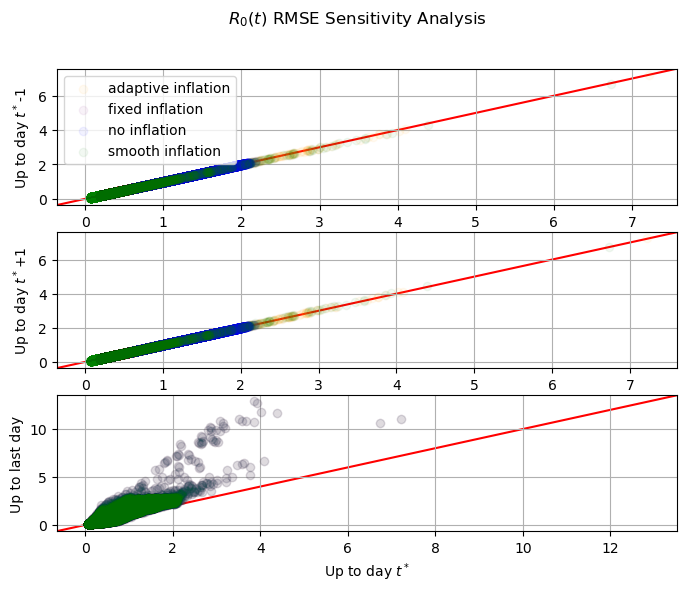

In [21]:
plot_sensitivity('rt_rmse_last_epi_day', 'rt_rmse_before_last_epi_day', 'rt_rmse_after_last_epi_day', 'rt_rmse', r"$R_0(t)$ RMSE Sensitivity Analysis")

### In CI

Percent differences: -0.382% 0.394% 168.2159%


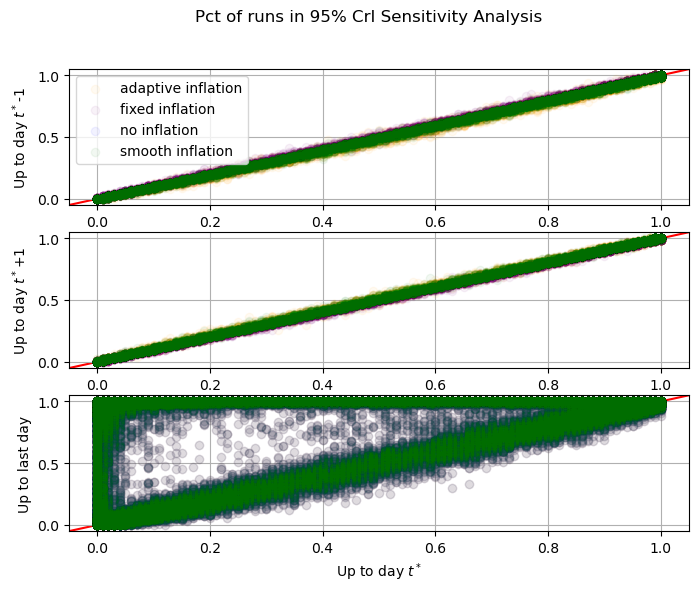

In [22]:
# computes on the actual day not up to
plot_sensitivity('in_ci_last_epi_day', 'in_ci_before_last_epi_day', 'in_ci_after_last_epi_day', 'in_ci_last_day', r"Pct of runs in 95% CrI Sensitivity Analysis")

### Avg $W_2(p,q)$

Percent differences: 0.0% 0.0% 0.0231%


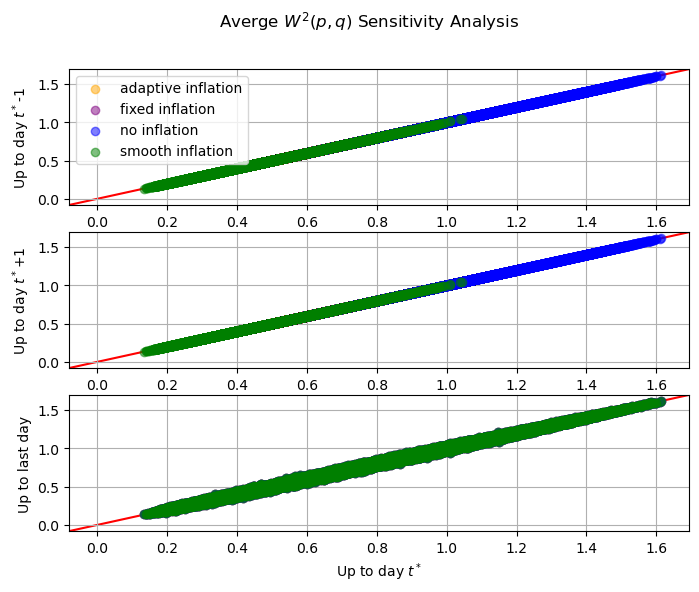

In [67]:
plot_sensitivity('avg_w2_last_epi_day', 'avg_w2_before_last_epi_day', 'avg_w2_after_last_epi_day', 'avg_w2', r"Averge $W^2(p,q)$ Sensitivity Analysis")

### Avg $D_{KL}(p \| q)$

Percent differences: 0.0% 0.0% 0.1624%


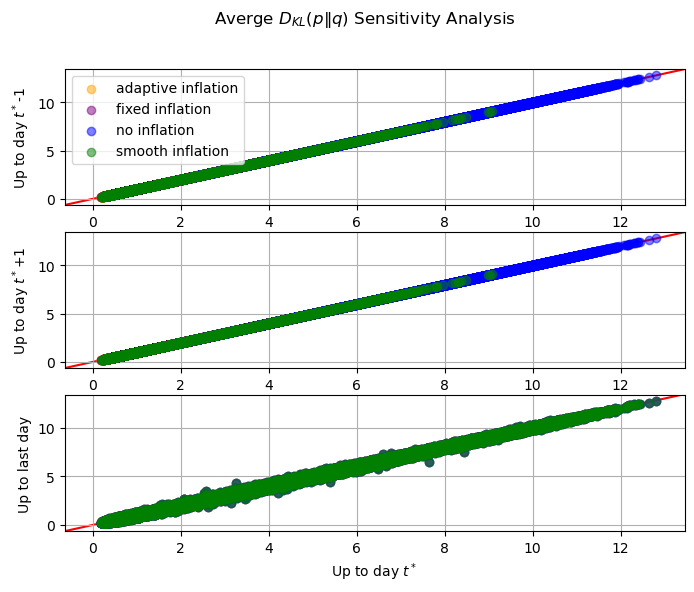

In [68]:
plot_sensitivity('avg_kl_last_epi_day', 'avg_kl_before_last_epi_day', 'avg_kl_after_last_epi_day', 'avg_kl', r"Averge $D_{KL}(p\|q)$ Sensitivity Analysis")

In [69]:
reliability_files = glob.glob("/ifs/scratch/jls106_gp/nhw2114/data/20240212_run/*_reliability.csv")
print(len(reliability_files))

reliability_df = pd.read_csv(reliability_files[0])
reliability_df.head()

47871


,percentile,adaptive,adaptive_beta,no,no_beta,fixed,fixed_beta,smooth,smooth_beta,param
0,2.5,0.016053,0.014857,0.014868,0.000943,0.053816,0.019257,0.018289,0.004399,44198
1,5.0,0.031930,0.029771,0.030351,0.001743,0.103860,0.045514,0.038772,0.008680,44198
2,7.5,0.046974,0.043229,0.046228,0.002800,0.149649,0.075000,0.057061,0.012287,44198
3,10.0,0.062632,0.057200,0.062500,0.003943,0.189649,0.103943,0.079386,0.015718,44198
4,12.5,0.083246,0.070800,0.077325,0.005057,0.224474,0.124686,0.105351,0.019443,44198


# Params with bad metrics for adaptive inflation

In [51]:
merge_df.columns

Index(['method', 'rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
       'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl', 'in_ci',
       'ens_var', 'in_ci_last_day', 'ens_var_last_day', 'in_ci_last_epi_day',
       'ens_var_last_epi_day', 'avg_w2_last_epi_day', 'avg_kl_last_epi_day',
       'param'],
      dtype='object')

In [47]:
merge_df.loc[(merge_df.method == "adaptive inflation") & (merge_df.in_ci_last_epi_day < 0.1), "param"].count() / merge_df.loc[merge_df.method == "adaptive inflation", "param"].count()

0.09788807419941091

In [52]:
merge_df.loc[(merge_df.method == "adaptive inflation") & (merge_df.rt_last_epi_day_rmse > 0.38), "param"].count() / merge_df.loc[merge_df.method == "adaptive inflation", "param"].count()

0.34613858076915044

In [59]:
merge_df.loc[merge_df.method == "adaptive inflation", "param"].count()

47871

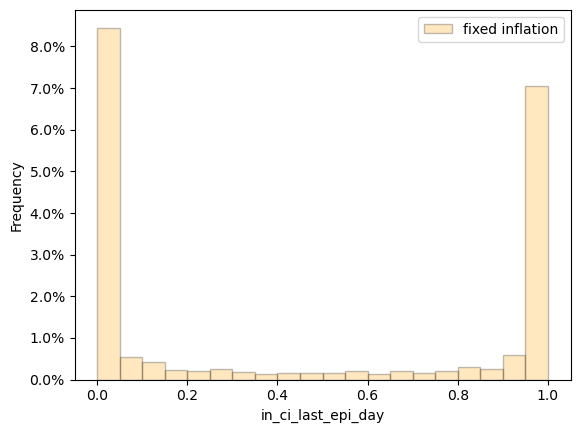

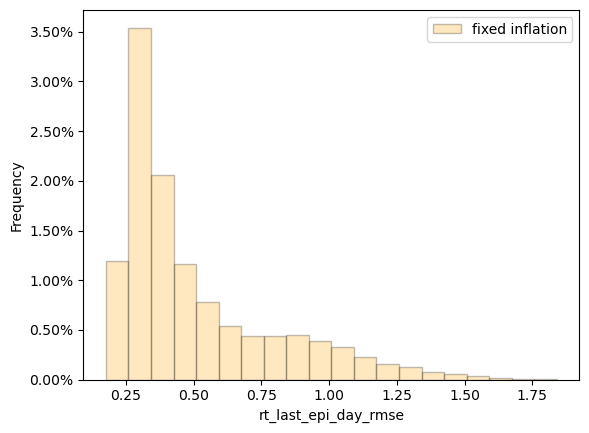

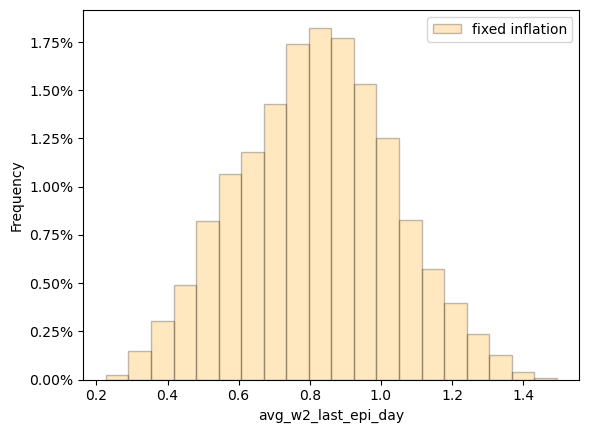

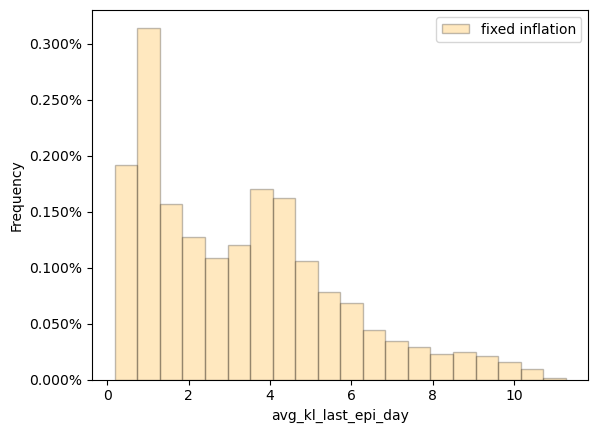

In [58]:
cols = [
    'in_ci_last_epi_day',
    'rt_last_epi_day_rmse',
    'avg_w2_last_epi_day',
    'avg_kl_last_epi_day',
]
for col in cols:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    no_ci = merge_df.loc[merge_df["method"] == "no inflation", col]
    fix_ci = merge_df.loc[merge_df["method"] == "fixed inflation", col]
    adapt_ci = merge_df.loc[merge_df["method"] == "adaptive inflation", col]
    smooth_ci = merge_df.loc[merge_df["method"] == "smooth", col]
    # ax.hist(no_ci, bins=20, color='green', label="no inflation", edgecolor='black', alpha=0.25, density=True, range=[0.0, 1.0])
    ax.hist(fix_ci, bins=20, color='orange', label="fixed inflation", edgecolor='black', alpha=0.25, density=True)
    # ax.hist(adapt_ci, bins=20, color='blue', label="adaptive inflation", edgecolor='black', alpha=0.25, density=True) 
    # ax.hist(smooth_ci, bins=20, color='red', label="smoothing", edgecolor='black', alpha=0.25, density=True) 

    ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.legend()

# Look for examples params for figures

In [15]:
len(np.unique(merge_df.param))

47871

In [16]:
table_cols = [
    'method',
    'in_ci_last_epi_day',
    'rt_last_epi_day_rmse',
    'avg_w2_last_epi_day',
    'avg_kl_last_epi_day',
]

max_params = merge_df.iloc[merge_df[table_cols].groupby("method").idxmax().values.flatten()].param.unique()
min_params = merge_df.iloc[merge_df[table_cols].groupby("method").idxmin().values.flatten()].param.unique()

# append the min and max params for epiestim
epiesim_max_params = epiestim_metrics_df.iloc[epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmax().values].param.unique()
epiesim_min_params = epiestim_metrics_df.iloc[epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmin().values].param.unique()

max_params = np.unique(np.append(max_params, epiesim_max_params))
min_params = np.unique(np.append(min_params, epiesim_min_params))

In [17]:
# params that are closest to the mean metric value

mean_df = merge_df[table_cols].groupby('method').mean()
mean_df.columns = mean_df.columns + "_mean"

mean_diff_df = merge_df[table_cols + ['param']].merge(mean_df, on="method")
mean_diff_df['in_ci_last_epi_day'] = np.abs(mean_diff_df['in_ci_last_epi_day'] - mean_diff_df['in_ci_last_epi_day_mean'])
mean_diff_df['rt_last_epi_day_rmse'] = np.abs(mean_diff_df['rt_last_epi_day_rmse'] - mean_diff_df['rt_last_epi_day_rmse_mean'])
mean_diff_df['avg_w2_last_epi_day'] = np.abs(mean_diff_df['avg_w2_last_epi_day'] - mean_diff_df['avg_w2_last_epi_day_mean'])
mean_diff_df['avg_kl_last_epi_day'] = np.abs(mean_diff_df['avg_kl_last_epi_day'] - mean_diff_df['avg_kl_last_epi_day_mean'])

mean_params = mean_diff_df.iloc[mean_diff_df[table_cols + ['param']].groupby("method").idxmin().values.flatten()].param.unique()

# append epiestim mean params
epiestim_mean_df = epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].mean()
mean_params = np.append(mean_params, [epiestim_metrics_df.iloc[np.abs(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, tt] - epiestim_mean_df[tt]).idxmin()].param for tt in table_cols[1:]])

In [25]:
mean_diff_df[table_cols + ['param']].groupby("method").idxmin()

,in_ci_last_epi_day,rt_last_epi_day_rmse,avg_w2_last_epi_day,avg_kl_last_epi_day,param
method,,,,,
adaptive inflation,0,17837,17260,12649,15367
fixed inflation,49712,93422,51475,54487,63238
no inflation,96509,98664,138052,121894,111109
smooth inflation,144104,171821,151930,179935,158980


In [36]:
mean_diff_df.iloc[17260].param

43056

In [18]:
max_df = merge_df[table_cols].groupby("method").idxmax().reset_index()
max_epi_df = pd.DataFrame(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmax()).T
max_epi_df["method"] = "epiestim"
max_df = pd.concat([max_df, max_epi_df])
max_df["example"] = "max"

min_df = merge_df[table_cols].groupby("method").idxmin().reset_index()
min_epi_df = pd.DataFrame(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, table_cols[1:]].idxmin()).T
min_epi_df["method"] = "epiestim"
min_df = pd.concat([min_df, min_epi_df])
min_df["example"] = "min"

mean_df = mean_diff_df[table_cols + ['param']].groupby("method").idxmin().reset_index()
dd = {tt : [epiestim_metrics_df.iloc[np.abs(epiestim_metrics_df.loc[epiestim_metrics_df.window == 8, tt] - epiestim_mean_df[tt]).idxmin()].param] for tt in table_cols[1:]}
mean_epi_df = pd.DataFrame.from_dict(dd)
mean_epi_df["method"] = "epiestim"
mean_df = pd.concat([mean_df, mean_epi_df])
mean_df["example"] = "mean"
mean_df.drop(["param"], axis=1, inplace=True)

list_df = pd.concat([max_df, min_df, mean_df])
list_df.to_csv("example_params_for_plots.csv", index=False)

In [19]:
params = np.append(min_params, max_params)
params = np.append(params, mean_params)
params = np.unique(params)
params

array([     1,      2,    190,   1337,   2236,   3348,   3457,   3775,
         4616,   5863,   6115,   8019,   8298,  16729,  21258,  26094,
        27533,  28485,  32062,  36206,  40299,  43056,  43775,  44331,
        45193,  46482,  49477,  54589,  55685,  55741,  57066,  57072,
        58428,  60945,  60997,  63679,  66815,  69090,  70286,  73071,
        84882,  85084,  89399,  96475,  96799,  96956,  97638,  98225,
        99368,  99403, 100184, 100185])

In [20]:
plot_dir = "/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"

files = os.listdir(plot_dir)
done_params = [int(f.split("_")[0]) for f in files if "epiEstim_for_plot.csv" in f]

to_do_params = list(set(params) - set(done_params))
to_do_params

[]

In [38]:
import re
import pickle
from matplotlib.backends.backend_pdf import PdfPages


plot_dir = "/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"
files = os.listdir(plot_dir)

param_df = pd.read_csv("param_list.csv")

def open_pickle_rt(pickle_file, smooth=False, plot_dir="/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"):
    with open(f"{plot_dir}/{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    if smooth:
        array = np.array([θ.beta*θ.t_I for θ in data.θ_lag_list])
    else:
        array = np.array([θ.beta*θ.t_I for θ in data.θ_list])
    return array

def open_pickle_data(pickle_file, smooth=False, plot_dir="/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"):
    with open(f"{plot_dir}/{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    array = np.array([x.i for x in data.x_list])
    data = data.data.i
    return array, data

def compute_ci_mean(array, confidence_level=95):
    ci = np.percentile(array, [100 - confidence_level, confidence_level], axis=1)
    mean = np.mean(array, axis=1)
    return ci, mean

def get_truth(pickle_file, plot_dir="/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/"):
    with open(f"{plot_dir}/{pickle_file}", 'rb') as file:
        data = pickle.load(file)
    return data.data.rt


last_day_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/last_epidemic_day.csv")
pdf_file = f"{plot_dir}/example_params_rt_obs_metrics.pdf"

adapt_params = [55685, 98225, 100184, 85084, 190, 97638, 57072, 46482, 66815, 5863, 43056]

adapt_titles = {
    55685  : r"Best calibration",
    98225  : r"Worst RMSE",
    100184 : r"Worst $D_{KL}$",
    85084  : r"Worst $W^2$",
    26094  : r"Worst calibration",
    190    : r"Best RMSE",
    97638  : r"Best $D_{KL}$",
    57072  : r"Best $W^2$",
    46482  : r"Avg calibration",
    66815  : r"Avg RMSE",
    5863   : r"Avg $D_{KL}$",
    43056  : r"Avg $W^2$",
}

pdf_file = f"{plot_dir}/example_adapt_params_rt_obs_metrics.pdf"
with PdfPages(pdf_file) as pdf:
    for pp in tqdm(adapt_params):
    # for pp in tqdm(params):
        epiestim_df = pd.read_csv(f"{plot_dir}/{pp}_epiEstim_for_plot.csv")
        epiestim_df = epiestim_df.loc[epiestim_df.window == 8]
        last_day = last_day_df.loc[last_day_df.param == pp, 'last_epidemic_day'].values[0]
        for run in range(1):
            no_pickle_file = f"{pp}_no_inflation_run_{run}.pkl"
            fixed_pickle_file = f"{pp}_fixed_inflation_run_{run}.pkl"
            adapt_pickle_file = f"{pp}_adaptive_inflation_run_{run}.pkl"
            smooth_pickle_file = f"{pp}_smooth_inflation_run_{run}.pkl"

            # get rt estimates and truth
            truth = get_truth(no_pickle_file)
            ci_no, mean_no = compute_ci_mean(open_pickle_rt(no_pickle_file))
            ci_fixed, mean_fixed = compute_ci_mean(open_pickle_rt(fixed_pickle_file))
            ci_adapt, mean_adapt = compute_ci_mean(open_pickle_rt(adapt_pickle_file))
            ci_smooth, mean_smooth = compute_ci_mean(open_pickle_rt(smooth_pickle_file, smooth=True))

            i_no, i_obs = open_pickle_data(no_pickle_file)
            ci_i_no, mean_i_no = compute_ci_mean(i_no)
            i_fixed, _ = open_pickle_data(fixed_pickle_file)
            ci_i_fixed, mean_i_fixed = compute_ci_mean(i_fixed)
            i_adapt, _ = open_pickle_data(adapt_pickle_file)
            ci_i_adapt, mean_i_adapt = compute_ci_mean(i_adapt)
            i_smooth, _ = open_pickle_data(smooth_pickle_file)
            ci_i_smooth, mean_i_smooth = compute_ci_mean(i_smooth)

            fig, ax = plt.subplots(2,2)
            fig.suptitle(adapt_titles[pp])
            fig.set_figheight(12)
            fig.set_figwidth(16)

            # plot Rt
            ax[0,0].fill_between(np.arange(ci_no.shape[1]), ci_no[0,:], ci_no[1,:], color='blue', alpha=0.3)
            ax[0,0].plot(mean_no, color="blue", label=r"EAKF with no inflation")

            ax[0,0].fill_between(np.arange(ci_fixed.shape[1]), ci_fixed[0,:], ci_fixed[1,:], color='purple', alpha=0.3)
            ax[0,0].plot(mean_fixed, color="purple", label=r"EAKF with fixed inflation")

            ax[0,0].fill_between(np.arange(ci_adapt[0,:].shape[0]), ci_adapt[0,:], ci_adapt[1,:], color='yellow', alpha=0.3)
            ax[0,0].plot(mean_adapt, color="orange", label=r"EAKF with adaptive inflation")

            ax[0,0].fill_between(np.arange(ci_smooth.shape[1]), ci_smooth[0,:], ci_smooth[1,:], color='green', alpha=0.3)
            ax[0,0].plot(mean_smooth, color="green", label=r"EnSRS (smoothing) with adaptive inflation")

            ax[0,0].fill_between(epiestim_df.day, epiestim_df['2.5%'], epiestim_df['97.5%'], color='grey', alpha=0.3)
            ax[0,0].plot(epiestim_df.day, epiestim_df['mean'], color='black', label=r"EpiEstim")

            ax[0,0].vlines(last_day, 0.01, ax[0,0].get_ylim()[1], color='steelblue', label='last epi day')

            ax[0,0].plot(truth, color="red", label=r"Synthetic truth")

            ax[0,0].set_xlabel("day", fontsize=12)
            ax[0,0].set_ylabel(r"$R_t$", fontsize=12)

            ax[0,0].legend()
            ax[0,0].grid()

            param_dict = param_df.iloc[pp-1][['rt_0', 'rt_1', 'k', 'midpoint']]
            ax[0,0].set_title(f"param {pp} run {run} {round(param_dict,3).to_dict()}")

            # table for metrics
            pp_kf_df = merge_df.loc[merge_df.param == pp, table_cols].round(3)
            pp_ep_df = epiestim_metrics_df.loc[(epiestim_metrics_df.window == 8) & (epiestim_metrics_df.param == pp), table_cols[1:]].round(3)
            pp_ep_df['method'] = 'epiestim'

            pp_df = pd.concat([pp_kf_df, pp_ep_df])
            custom_order = ['no inflation', 'fixed inflation', 'adaptive inflation', 'smooth inflation', 'epiestim']
            pp_df['method'] = pd.Categorical(pp_df['method'], categories=custom_order, ordered=True)
            pp_df = pp_df.sort_values(by='method')

            ax[0,1].axis('off')
            table = ax[0,1].table(cellText=pp_df.values, colLabels=pp_df.columns, loc='center')
            table.set_fontsize(24)
            table.scale(1.3, 1.3)

            # plot i
            ax[1,0].fill_between(np.arange(ci_i_no.shape[1]), ci_i_no[0,:], ci_i_no[1,:], color='blue', alpha=0.3)
            ax[1,0].plot(mean_i_no, color="blue", label=r"EAKF with no inflation")

            ax[1,0].fill_between(np.arange(ci_i_fixed.shape[1]), ci_i_fixed[0,:], ci_i_fixed[1,:], color='purple', alpha=0.3)
            ax[1,0].plot(mean_i_fixed, color="purple", label=r"EAKF with fixed inflation")

            ax[1,0].fill_between(np.arange(ci_i_adapt[0,:].shape[0]), ci_i_adapt[0,:], ci_i_adapt[1,:], color='yellow', alpha=0.3)
            ax[1,0].plot(mean_i_adapt, color="orange", label=r"EAKF with adaptive inflation")

            ax[1,0].fill_between(np.arange(ci_i_smooth.shape[1]), ci_i_smooth[0,:], ci_i_smooth[1,:], color='green', alpha=0.3)
            ax[1,0].plot(mean_i_smooth, color="green", label=r"EnSRS (smoothing) with adaptive inflation")

            ax[1,0].vlines(last_day, 0.01, ax[1,0].get_ylim()[1], color='steelblue', label='last epi day')

            ax[1,0].plot(i_obs, '.', color='red', label='observations')

            ax[1,0].set_xlabel("day", fontsize=12)
            ax[1,0].set_ylabel(r"daily case counts", fontsize=12)

            ax[1,0].legend()
            ax[1,0].grid()


            ax[1,1].axis('off')

            pdf.savefig(fig)
            plt.close()

            # plt.savefig(f'rt.svg', format='svg', bbox_inches='tight', transparent=True)

        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:13<00:00,  1.22s/it]


# Compute correlations with params

In [15]:
param_df = pd.read_csv("param_list.csv")
param_df["param"] = param_df.index

In [16]:
param_df['early_day'] = -1/param_df.k * np.log((param_df.rt_1 - param_df.rt_0)/(1.01*param_df.rt_0 - param_df.rt_0)-1) + param_df.midpoint
param_df['late_day'] = -1/param_df.k * np.log((param_df.rt_1 - param_df.rt_0)/(0.99*param_df.rt_1 - param_df.rt_0)-1) + param_df.midpoint
param_df['day_diff'] = param_df['late_day'] - param_df['early_day']
param_df['rt_diff'] = param_df['rt_1'] - param_df['rt_0']

In [17]:
merge_df = merge_df.merge(param_df, on="param")
epiestim_metrics_df = epiestim_metrics_df.merge(param_df, on="param")

In [18]:
metric_cols = ['rt_peak_rmse', 'rt_rmse', 'rt_last_epi_day_rmse',
       'data_rmse', 'data_rmse_last_epi_day', 'avg_w2', 'avg_kl', 'in_ci',
       'ens_var', 'in_ci_last_day', 'ens_var_last_day', 'in_ci_last_epi_day',
       'ens_var_last_epi_day', 'avg_w2_last_epi_day', 'avg_kl_last_epi_day']
param_cols = ['rt_0', 'rt_1', 'midpoint', 'k', 'early_day', 'late_day', 'day_diff', 'rt_diff']

In [ ]:
from sklearn.manifold import TSNE
X = param_df.loc[param_df.param.isin(merge_df.param), ['rt_0', 'rt_1', 'midpoint', 'k']]
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

# Add legends and labels
plt.title('t-SNE Plot of Parameters for Synthetic Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Show the plot
plt.show()

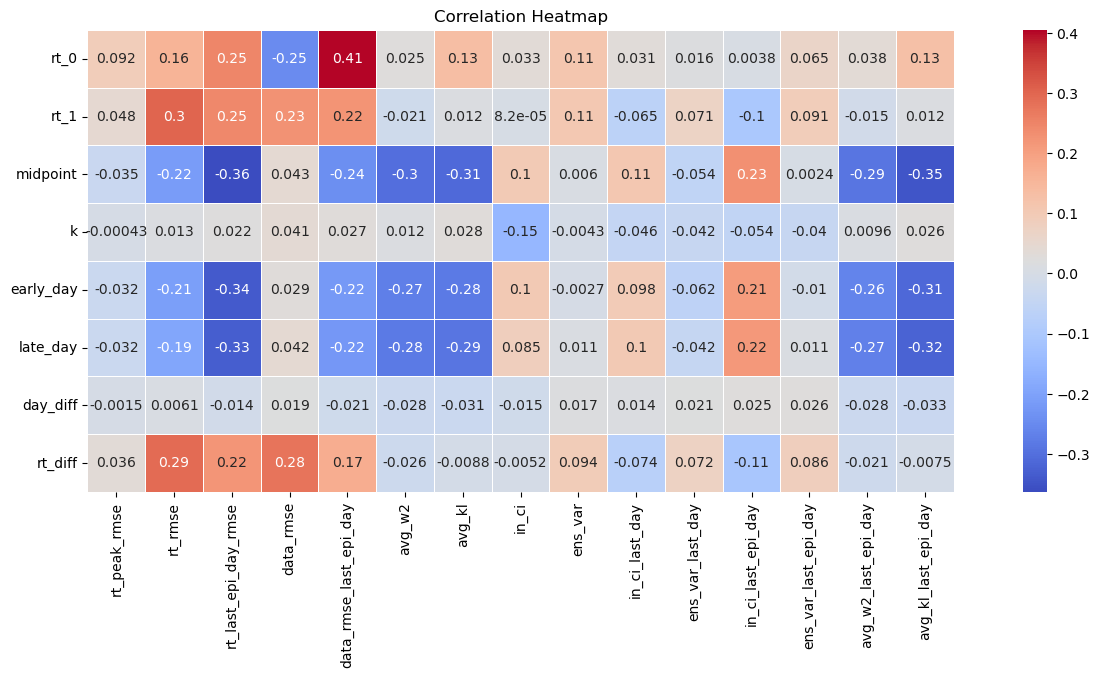

In [19]:
import seaborn as sns

correlation_matrix = merge_df[metric_cols + param_cols].corr()
correlation_matrix_subset = correlation_matrix.loc[correlation_matrix.index.isin(param_cols),metric_cols]

# Create a heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix_subset, annot=True, cmap='coolwarm', linewidths=.5, square=True)

# Customize the plot
plt.title('Correlation Heatmap')
plt.show()

correlation_matrix_subset.to_csv("correlation.csv", index=False)

In [20]:
# move files
# files = glob.glob(dir + '/*epiEsim_plots.pdf')

# new_dir = "/ifs/scratch/jls106_gp/nhw2114/data/20231106_synthetic_data/pdf_archive/"
# for f in tqdm(files):
#     new_path = new_dir + os.path.basename(f)
#     os.rename(f, new_path)


In [49]:
merge_df

,method,rt_peak_rmse,rt_rmse,rt_last_epi_day_rmse,data_rmse,data_rmse_last_epi_day,avg_w2,avg_kl,in_ci,ens_var,in_ci_last_day,ens_var_last_day,in_ci_last_epi_day,ens_var_last_epi_day,avg_w2_last_epi_day,avg_kl_last_epi_day,param
0,adaptive inflation,0.049659,0.297835,0.345252,44.866206,37.157531,0.748936,1.009969,1.00,0.110539,1.00,0.060434,0.84,0.010794,0.748936,1.009969,46482
1,fixed inflation,0.033103,0.383044,0.468907,82.805262,37.157531,1.107686,5.460655,0.00,0.017664,0.01,0.004569,0.01,0.004589,1.107686,5.460655,46482
2,no inflation,0.017554,1.853739,1.237215,119.336936,37.157531,1.302610,9.297477,0.00,0.000145,0.00,0.000137,0.00,0.000139,1.302610,9.297477,46482
3,smooth inflation,0.046107,0.199183,0.161448,58.528608,34.100729,0.360093,0.876703,0.98,0.007663,1.00,0.055704,0.82,0.010864,0.360093,0.876703,46482
4,adaptive inflation,0.067297,0.284295,0.358944,51.011642,32.296547,0.584976,0.634232,0.00,0.185233,1.00,0.055959,1.00,0.011951,0.584976,0.634232,55685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191479,smooth inflation,0.038696,0.417677,0.240091,84.693614,34.698801,0.411220,1.085326,0.01,0.002165,0.00,0.032739,0.00,0.004500,0.411220,1.085326,12832
191480,adaptive inflation,0.071103,0.314759,0.353565,42.761432,44.875284,0.664482,0.991589,1.00,0.119198,1.00,0.143280,1.00,0.028737,0.664482,0.991589,84965
191481,fixed inflation,0.040929,0.519223,0.538571,50.410305,44.875284,1.102473,5.389573,0.77,0.088312,0.86,0.068502,0.88,0.069846,1.102473,5.389573,84965
191482,no inflation,0.020984,2.028184,1.558854,74.681456,44.875284,1.376654,10.761614,0.00,0.000230,0.00,0.000215,0.00,0.000217,1.376654,10.761614,84965


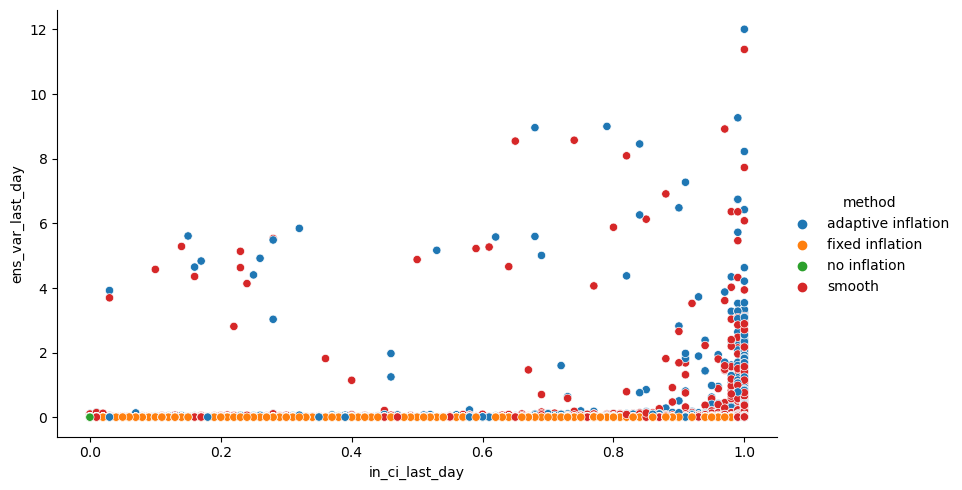

In [21]:
import seaborn as sns

_methods = ['adaptive inflation', 'fixed inflation', 'no inflation', 'smooth']
sns.relplot(data=eakf_metrics_df, x='in_ci_last_day', y='ens_var_last_day', hue='method', hue_order=_methods, aspect=1.61)
plt.show()

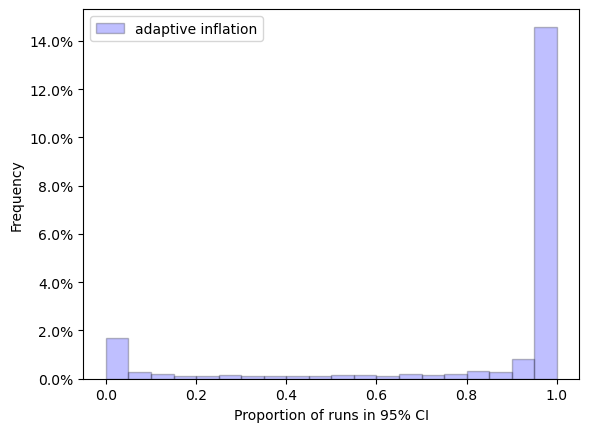

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
no_ci = merge_df.loc[merge_df["method"] == "no inflation", "in_ci_last_day"]
fix_ci = merge_df.loc[merge_df["method"] == "fixed inflation", "in_ci_last_day"]
adapt_ci = merge_df.loc[merge_df["method"] == "adaptive inflation", "in_ci_last_epi_day"]
smooth_ci = merge_df.loc[merge_df["method"] == "smooth", "in_ci_last_day"]
# ax.hist(no_ci, bins=20, color='green', label="no inflation", edgecolor='black', alpha=0.25, density=True, range=[0.0, 1.0])
# ax.hist(fix_ci, bins=20, color='orange', label="fixed inflation", edgecolor='black', alpha=0.25, density=True)
ax.hist(adapt_ci, bins=20, color='blue', label="adaptive inflation", edgecolor='black', alpha=0.25, density=True) 
# ax.hist(smooth_ci, bins=20, color='red', label="smoothing", edgecolor='black', alpha=0.25, density=True) 

ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
plt.xlabel('Proportion of runs in 95% CI')
plt.ylabel('Frequency')
plt.legend()

In [24]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# no_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "no inflation", "ens_var_last_day"]
# # fix_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "fixed inflation", "ens_var_last_day"]
# adapt_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", "ens_var_last_day"]
# smooth_ci = eakf_metrics_df.loc[eakf_metrics_df["method"] == "smooth", "ens_var_last_day"]

# # ax.hist(no_ci, bins=5, color='green', label="no inflation", edgecolor='black', alpha=0.25, density=True, range=[0.0, 1.0])
# ax.hist(fix_ci, bins=5, color='orange', label="fixed inflation", edgecolor='black', alpha=0.25, density=True)
# ax.hist(adapt_ci, bins=5, color='blue', label="adaptive inflation", edgecolor='black', alpha=0.25, density=True) 
# ax.hist(smooth_ci, bins=5, color='red', label="smoothing", edgecolor='black', alpha=0.25, density=True) 

# # ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
# plt.title('Histogram Example')
# plt.xlabel('Ensemble Variance')
# plt.ylabel('Frequency')
# plt.legend()

In [16]:
# from scipy.stats.kde import gaussian_kde

# x = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", "in_ci_last_day"]
# y = eakf_metrics_df.loc[eakf_metrics_df["method"] == "adaptive inflation", "ens_var_last_day"]
# Z, xedges, yedges = np.histogram2d(x, y,bins=5)
# plt.pcolormesh(xedges, yedges, Z.T)
# plt.colorbar()



# MISC

In [43]:
dir = "/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/pdf_archive"
len(os.listdir(dir))

218167

# Compute last day

In [188]:
import pickle
from epyfilter import simulate_data

good_param_df = pd.read_csv("good_param_list.csv")
pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in good_param_df.param]

def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

last_day_array = np.empty(shape=(len(pickle_list), 2))

array([   0,   40,   59,   71,   71,   85,  102,  124,  156,  192,  222,
        252,  313,  371,  429,  468,  559,  625,  751,  823,  984, 1111,
       1304, 1369, 1573, 1705, 1967, 2082, 2248, 2428, 2532, 2665, 2783,
       2819, 2791, 2749, 2678, 2596, 2496, 2297, 2199, 2032, 1843, 1676,
       1551, 1358, 1242, 1063, 1039,  942,  842,  691,  634,  536,  548,
        469,  436,  379,  332,  305,  289,  269,  272,  265,  252,  246,
        246,  223,  232,  219,  230,  231,  245,  245,  230,  264,  266,
        281,  295,  288,  314,  338,  354,  370,  392,  436,  404,  439,
        465,  408,  453,  450,  444,  395,  421,  399,  390,  378,  354,
        359,  330,  278,  295,  263,  259,  254,  224,  221,  192,  179,
        158,  168,  142,  117,  123,  100,   95,   91,   83,   80,   72,
         74,   64,   56,   50,   59,   48,   44,   38,   42,   42,   33,
         40,   33,   18,   30,   23,   32,   29,   20,   13,   11,    9,
         12,   12,    9,   10,   12,    7,    4,   

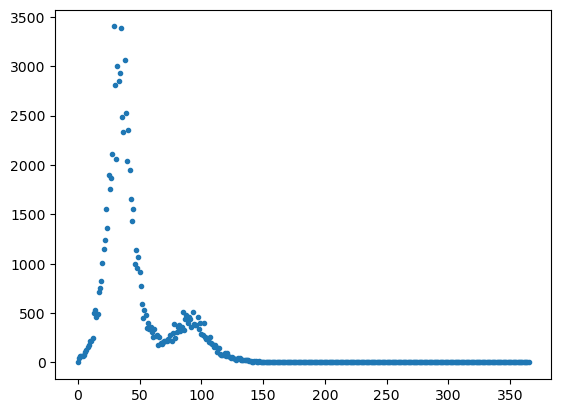

In [313]:
pp = 98225
data = open_pickle(f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{pp}_synthetic_data.pkl")
plt.plot(data.i, '.')
np.where(data.i_true == 0)
data.i_true

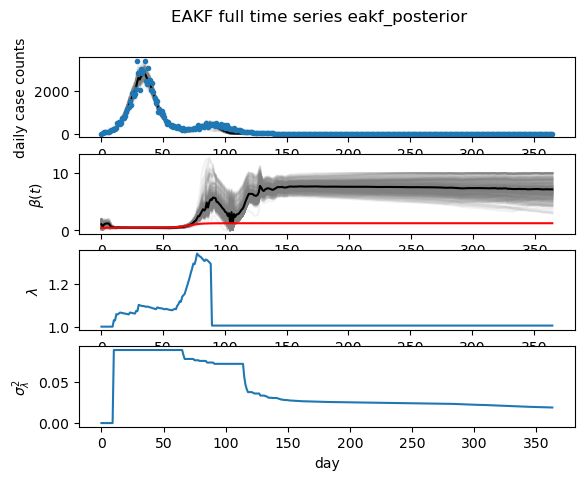

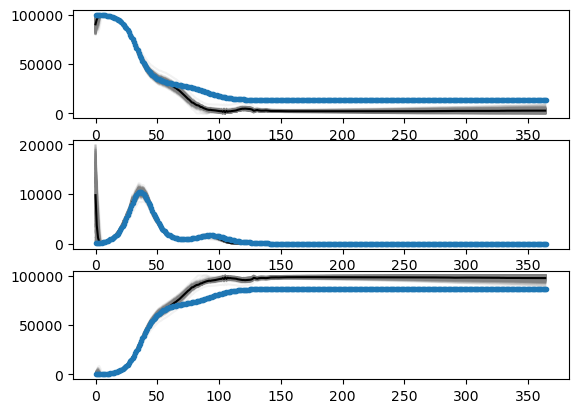

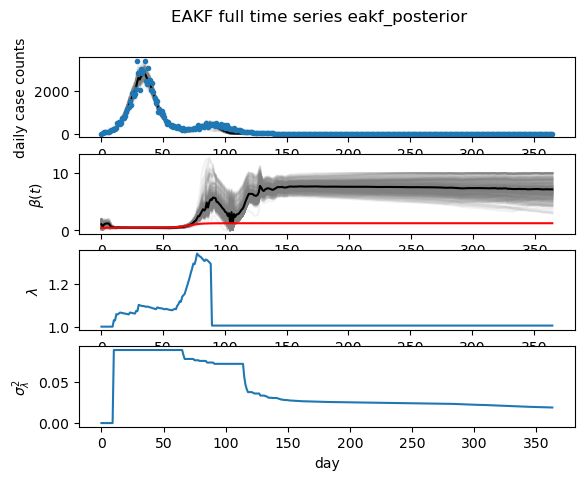

In [322]:
kf_adapt = open_pickle(f"{plot_dir}/{pp}_adaptive_inflation_run_{run}.pkl")
kf_adapt.plot_posterior()

In [60]:
for i, pp in enumerate(tqdm(pickle_list)):
    param = os.path.basename(pp).split("_")[0]
    data = open_pickle(pp)
    if len(np.where(data.i_true == 0)[0]) == 1:
        last_day = len(data.i_true)
    else:
        last_day = np.where(data.i_true == 0)[0][1]
    last_day_array[i] = [param, last_day]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47871/47871 [35:25<00:00, 22.52it/s]


In [66]:
last_day_df = pd.DataFrame(last_day_array, columns=['param','last_epidemic_day'], dtype=int)
last_day_df.to_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/last_epidemic_day.csv", index=False)

In [69]:
last_day_df[last_day_df.last_epidemic_day.isna()]

,param,last_epidemic_day


# Fix last epi day

In [22]:
last_day_df = pd.read_csv("/ifs/scratch/jls106_gp/nhw2114/repos/rt-estimation/src/epyfilter/c2b2/last_epidemic_day.csv")

In [44]:
to_do_params = []
last_epi_days = []

for index, row in tqdm(last_day_df.iterrows()):
    param = row['param']
    last_epi_day = row['last_epidemic_day']
    pp = f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl"
    data = open_pickle(pp)
    zero_days = np.where(data.i_true == 0)[0]
    if len(zero_days) == 1:  # never reached 0
        last_day = len(data.i_true)
    else:
        first_zero_day = zero_days[1]
        non_zero_days = np.where(data.i_true > 10)[0]
        if np.any(non_zero_days > first_zero_day):
            last_days = zero_days[zero_days > np.max(non_zero_days)]
            if len(last_days) == 0:
                last_day = len(data.i_true)
            else:
                last_day = last_days[0]
        else:
            last_day = first_zero_day
    if last_epi_day != last_day:
        to_do_params.append(param)
        last_epi_days.append(last_day)
        

47871it [1:23:21,  9.57it/s]


In [57]:
pd.DataFrame(np.array((to_do_params, last_epi_days)).T, columns=["param", "last_epi_day"]).to_csv("to_do_params_last_epi_day.csv", index=False)

In [38]:
# for param in to_do_params[0:10]:
#     pp = f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl"
#     data = open_pickle(pp)
#     last_epi_day = last_day_df.loc[last_day_df.param == param, 'last_epidemic_day'].values[0]
#     plt.plot(data.i_true, '.')
#     plt.axvline(x = last_epi_day)

array([  0, 162, 173, 174, 175, 176, 177, 179, 182, 184, 186])

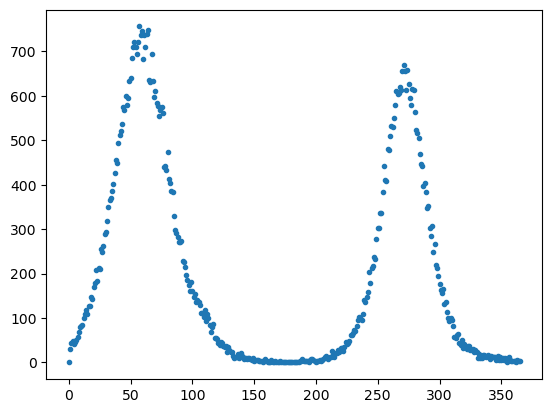

In [29]:
plt.plot(data.i_true, '.')
np.where(data.i_true == 0)[0]

In [22]:
import pickle
from epyfilter import simulate_data
from tqdm import tqdm

# good_param_df = pd.read_csv("good_param_list.csv")
# pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in good_param_df.param]

def compute_late_day(data):
    beta_1 = data.rt_1 / data.t_I
    beta_0 = data.rt_0 / data.t_I
    late_day = -1/data.k * np.log((beta_1 - beta_0)/(0.99*beta_1 - beta_0)-1) + data.midpoint
    late_day = int(late_day)
    return late_day

def compute_peaks(data):
    det_data = simulate_data.simulate_data(**data.true_params, run_deterministic=True)
    peak_days, = np.where(np.diff(np.sign(np.diff(det_data.i_true))) == -2)  # days where it increases before then decreases
    peak_days = peak_days[:2]  # just take first two days
    return peak_days

def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

In [27]:
# data_files = glob.glob(dir + '/*_data_distribution.csv')
# done_params = [int(os.path.basename(f).split("_")[0]) for f in data_files]
# todo_params = list(set(good_param_df.param) - set(done_params))

# pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{param}_synthetic_data.pkl" for param in todo_params]

In [28]:
# pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/{param}_synthetic_data.pkl" for param in params]

In [24]:
pickle_list = [f"/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/{param}_synthetic_data.pkl" for param in to_do_params]

In [25]:
for pp in tqdm(pickle_list):
    param = os.path.basename(pp).split("_")[0]
    data = open_pickle(pp)
    data_distribution_df = pd.DataFrame(data.data_distribution, columns=[f"sample{x}" for x in range(1,301)])
    data_distribution_df["day"] = range(len(data_distribution_df))
    data_distribution_df["late_day"] = compute_late_day(data)
    peaks = compute_peaks(data)
    data_distribution_df["peak1"] = peaks[0]
    data_distribution_df["peak2"] = peaks[1]
    
    data_distribution_df.to_csv(f"/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/{param}_data_distribution.csv", index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:03<00:00,  4.48it/s]


In [26]:
len(glob.glob('/ifs/scratch/jls106_gp/nhw2114/data/example_plots_for_paper/' + '/*_data_distribution.csv'))

52

# Fix Single Epidemics

In [7]:
pickles = glob.glob(dir + '/*.pkl')

In [8]:
import pickle
def open_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        data = pickle.load(file)
    return data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100185/100185 [3:04:18<00:00,  9.06it/s]


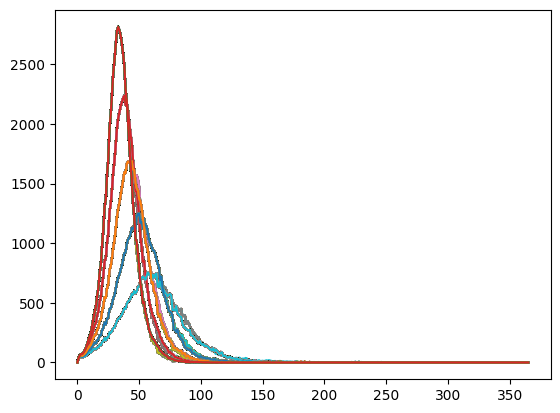

In [10]:
from tqdm import tqdm
from scipy.signal import find_peaks

bad_params = []
for file in tqdm(pickles):
    data = open_pickle(file)

    window_size = 10  # Adjust this window size as needed
    smoothed_data = np.convolve(data.i_true, np.ones(window_size) / window_size, mode='valid')
    peaks, _ = find_peaks(smoothed_data, height=100, prominence=10)
    if len(peaks) < 2:
        bad_params.append(file)
        plt.plot(data.i_true)

In [11]:
len(bad_params)

52314

In [14]:
pd.DataFrame(bad_params).to_csv("one_epidemic_curve.csv", index=False)

In [18]:
bad_metric_files = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{os.path.basename(b).split('_')[0]}_eakf_metrics.csv" for b in bad_params]

In [21]:
dfs = []
for file in tqdm(files):
    if file not in bad_metric_files:
        df = pd.read_csv(file)
        param = os.path.basename(file).split("_")[0]
        df["param"] = param
        dfs.append(df)

good_combined_df = pd.concat(dfs, ignore_index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100185/100185 [07:22<00:00, 226.36it/s]


In [22]:
good_combined_df[["method", "rt_peak_rmse", "rt_rmse", "data_rmse", "avg_w2", "avg_kl", "in_ci"]].groupby("method").mean()

,rt_peak_rmse,rt_rmse,data_rmse,avg_w2,avg_kl,in_ci
method,,,,,,
adaptive inflation,0.084815,0.374231,47.154245,0.642203,0.952536,0.662593
fixed inflation,0.044096,0.599377,68.936821,0.811197,3.306851,0.172927
no inflation,0.024710,1.763012,117.320087,0.988873,7.159461,0.000000
smooth,0.043557,0.253248,58.496632,0.383990,0.968416,0.543410


Text(0, 0.5, 'Count')

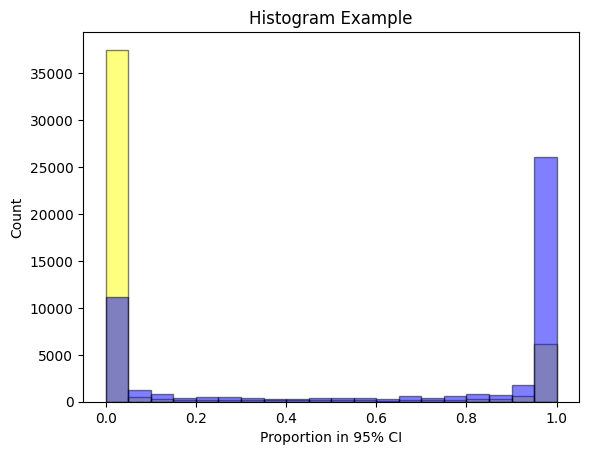

In [23]:
plt.hist(good_combined_df.loc[good_combined_df["method"] == "fixed inflation", "in_ci"], bins=20, color='yellow', edgecolor='black', alpha=0.5)
plt.hist(good_combined_df.loc[good_combined_df["method"] == "adaptive inflation", "in_ci"], bins=20, color='blue', edgecolor='black', alpha=0.5)
plt.title('Histogram Example')
plt.xlabel('Proportion in 95% CI')
plt.ylabel('Count')

In [42]:
pd.DataFrame(good_combined_df.param.unique(), columns=["param"]).to_csv("good_param_list.csv", index=False)

In [45]:
df = pd.read_csv("good_param_list.csv")
pickle_files = df.iloc[1:1000, 0]

In [46]:
pickle_files = [f"/ifs/scratch/jls106_gp/nhw2114/data/20231025_synthetic_data/{p}_synthetic_data.pkl" for p in pickle_files]

In [51]:
4788/200 * 3

71.82000000000001

In [55]:
files = glob.glob(dir + '/*_for_epiestim.csv')

In [58]:
pd.read_csv(files[0])

,rt,i,prop_S
0,1.3,33.742320,0.99869
1,1.3,42.500996,0.99826
2,1.3,45.972273,0.99778
3,1.3,38.297496,0.99736
4,1.3,38.854358,0.99690
...,...,...,...
360,4.7,0.000000,0.58860
361,4.7,0.396479,0.58860
362,4.7,0.000000,0.58860
363,4.7,0.000000,0.58860
